# Homework 1 CSCI 4364/6364 Machine Learning

## **ML Environment and Fundamentals**

**Due Date: 9/12/2023, 23:59 ET**

**Purpose**
This first homework assignment is to familiarize you with the libraries commonly used in machine learning applications, and apply them to some fundamental concepts, such cross-validation, and hyperparameter tuning, used frequently in model training and evaluation.

This homework touches on many practical considerations when training and evaluating machine learning models. It’s more structured than future assignments, which will be progressively less defined as you gain experience in applying your knowledge in machine learning.

Submission Instructions
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

Grading on the notebook
This notebook is worth 5% of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Important:** Please ensure that you save output when submitting the colab. You can verift this by going to Edit >> Settings and making sure the checkbox next to "Omit code output when saving notebook" is **NOT** checked.

Coding Standards
Throughout this course, we will use Google’s Python Style Guide (https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Toghrul Tahirov

**GW ID:** G47609664

In [120]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import tensorflow as tf
# TODO import Tensorflow datasets
import tensorflow_datasets as tfds
import pandas as pd # Pandas dataframe libaries
import numpy as np # Numpy numerical computation library
from sklearn.linear_model import LogisticRegression # Linear Classifier
from sklearn import metrics # Used to compute metrics, such as the Area Under the Curve (AUC)
import matplotlib.pyplot as plt # Plotting library.
from typing import List, Tuple, Mapping # Common types for Python type definitions
from tensorboard.plugins.hparams import api as hp # Library for Hyperparameter Tuning


# 1 Datasets
There are many datasets available in open source to try out machine learning algorithms. Besides being accessible and easy to use, many serve as well-known reference datasets that you can use to demonstrate general applicability in scientific publications.

In this assignment we’ll gain experience with  the [TensorFlow Data Set (TFDS)](https://www.tensorflow.org/datasets) by using the “[German Credit Numeric](https://www.tensorflow.org/datasets/catalog/german_credit_numeric)” data set.

You can use open source data sets or source your own non-proprietary data set for your semester project.

You can gain additional practice using TFDS by reviewing and executing the [colab](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb#scrollTo=Y0iVVStvk0oI).

Here, we simply load the German Credit Numeric dataset and convert the whole dataset to a Pandas dataframe. With larger data sets you may find it more efficient to load the data set and use `take(N)` to retrieve a smaller subsample incrementally.


In [121]:
#@title Download the data set from TensorFlow Datasets (TFDS)

# Source https://www.tensorflow.org/datasets/catalog/german_credit_numeric

ds, ds_info = tfds.load(
    'german_credit_numeric', split='train',
    shuffle_files=True, with_info = True)
df = tfds.as_dataframe(ds.take(1000), ds_info)

## Explorative Data Analysis

### Quick look at the data

In [122]:
ds_info

tfds.core.DatasetInfo(
    name='german_credit_numeric',
    full_name='german_credit_numeric/1.0.0',
    description="""
    This dataset classifies people described by a set of attributes as good or bad
    credit risks. The version here is the "numeric" variant where categorical and
    ordered categorical attributes have been encoded as indicator and integer
    quantities respectively.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)',
    data_path='C:\\Users\\togru\\tensorflow_datasets\\german_credit_numeric\\1.0.0',
    file_format=tfrecord,
    download_size=99.61 KiB,
    dataset_size=58.61 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(24,), dtype=int32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=1000, num_shards=1>,
    },
    citation="""@misc{Dua:2019 ,


In [123]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   features  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [124]:
X = df['features']
y = df['label']

In [125]:
X.shape, y.shape

((1000,), (1000,))

In [126]:
type(X), type(y)

(pandas.core.series.Series, pandas.core.series.Series)

In [127]:
# print the datatypes of the samples in X and y
X.dtype, y.dtype

(dtype('O'), dtype('int64'))

In [128]:
# check out the dimensions of the samples in X and their datatypes
X[0].shape, X[0].dtype

((24,), dtype('int32'))

In [129]:
# check the unique values in y
y.value_counts()

label
1    700
0    300
Name: count, dtype: int64

## Question 1.1
Describe the dataset you just downloaded. (a) How many examples and what types of features are there? (b) What do the labels represent?

## Answer

From the outputs of the above code block, we can see that the dataset has 1000 examples in terms of both the independent and dependent variables and both pandas.Series objects. The featuers data was extracted under the variable `X` and the labels were extracted under the variable `y`. Each row of the features dataset consists of a numpy array (np.ndarray) of **24** elements, thus the dataset is noted to contain 'object' type data. The 24 elements are all of type `int32`. These variables are the features of the dataset and each feature represents a certain characteristic of the credit applicant. Based on the explanation of the dataset, the features apparently include categorical features encoded as integers in addition to numerical features.

The labels are of type `int64` and each label represents the credit risk of the person in terms of good or bad. This is lucid from the info given in the tf dataset object and we can confirm this by looking at the output of the above code block where we can see that the labels are either 0 or 1. As stated in the dataset's source, 0 represents good credit risk and 1 represents bad credit risk. Judged by the distribution of the labels, since we 70% of the labels are 1 and 30% are 0, we can say that the dataset is fairly imbalanced.

## Data Wrangling

Unfortunately, the Pandas dataframe `df` isn’t exactly in the right format. In this step, convert the raw data frame into a concatenated numpy array $[X|y]$, where $X$ is an array with $M$ example rows $\times N$ feature columns and $y$ is the class label array with shape  $M \times 1$.


Separate features and labels datasets have already been generated in the above steps, however the shape of the features dataset is not in the right format. The shape of the features dataset is (1000, 1) and we need to convert it to (1000, 24). We can do this by using the `np.vstack()` function which will vertically stack the nested np.array objects and result in the desired shape. 

We will also need to reshape the labels dataset to (1000, 1) as it is currently in the shape of (1000,). We can do this by using the `np.reshape()` function.

In [130]:
#@title Convert the dataset into an example array and a label array dataframe
# this step has already been done in the above section

# In this step, convert df into an numpy array called Xy.
X = X.values
y = y.values

In [131]:
# let's check the type of X and y to make sure they are numpy arrays
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

As we can see both the features and labels datasets are now numpy arrays as desired

In [132]:
# let's create a copy of the features dataset for future convenience
X_cpy = X.copy()

We'll now format both datasets into the desired shape through the methods described above. We'll then concatenate the two datasets into one dataset to get the desired shape of $[X|y]$.

In [133]:
# convert the np.ndarray of np.ndarray with shape Mx1 into a np.ndarray of int32 with shape MxN
X = np.vstack(X_cpy)

# convert the labels into a np.ndarray with shape Mx1
y = y.reshape(-1,1)

# let's confirm the shapes of X and y and the datatypes of their elements
print(f"X.shape = {X.shape}, X.dtype = {X.dtype}")
print(f"y.shape = {y.shape}, y.dtype = {y.dtype}")

X.shape = (1000, 24), X.dtype = int32
y.shape = (1000, 1), y.dtype = int64


We can see that the labels are of type int64, let's convert them to int32 for compatibility with the features dataset. This will eliminate the need for implicit type conversion when we concatenate the two datasets or when we use them in the future in our models. 

In [134]:
y = y.astype("int32")

In [135]:
# let's confirm the shapes of X and y and the datatypes of their elements
print(f"X.shape = {X.shape}, X.dtype = {X.dtype}")
print(f"y.shape = {y.shape}, y.dtype = {y.dtype}")

X.shape = (1000, 24), X.dtype = int32
y.shape = (1000, 1), y.dtype = int32


Now, both the features and labels datasets are of type int32 and in the desired shapes. We can now concatenate them into one dataset. I'll use the np.hstack() function to horizontally stack the two datasets which is a shorthand for concatenating the two datasets along axis 1. 

In [136]:
# converting the features and labels datasets into a single numpy array
Xy = np.hstack((X,y))

# confirming the shapes of the concatenated array
print(f"Shape of the combined dataset = {Xy.shape}")

Shape of the combined dataset = (1000, 25)


Sequential bias occurs when patterns contained in the dataset may shift and results are order dependent. Imagine this data set was ordered by applicants from different geographic regions with different cultural practices and habits. If you split the data into a training set and a test set without countering the biases, you may be evaluating the model on applicants with different patterns the model has never seen before. Perhaps worse, suppose you deployed the model with the hidden bias into the real world, and the model worked better for applicants from Hamburg than applicants from Bavaria, causing an unfair bias.

See also [Bias and unfairness in machine learning models: A systematic literature review](https://arxiv.org/pdf/2202.08176.pdf) for greater detail.

A simple and effective technique for mitigating sequential bias is to randomize the data set.


In [137]:
#@title Set a random seed prior to shuffle
np.random.seed(seed = 773)

## Question 1.2
What's the reason we seed a random number generator before shuffeling the data set?


## Answer
The reason we seed a random number generator before shuffling the dataset is to ensure that the shuffling is reproducible. If we don't seed the random number generator, the shuffling will be random each time the whole notebook is run and we won't be able to reproduce the same shuffling in the future.


 Most random number generators use the current time as the seed for the random number generator. This means that if we run the notebook at different times, the random number generator will use different seeds and the shuffling will be different each time. 

 This is important because we want to be able to train and compare the models on the same shuffled dataset and make sure that the dataset does not result in discrepancies in the performance of the models. 


In [138]:
#@title Randomize the order of the dataset
np.random.shuffle(Xy)

# 2 Train a basic Linear Classifier on the data

Next, we’ll train a Linear Classifier called [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) using Scikit-Learn. Logistic Regression is basically a linear regression with a softmax output, but don’t worry about the details yet - we’ll cover them in the coming weeks. Basically, we want to try out a linear classifier and see how it works “right out of the box.” This will serve as a baseline against which we’ll compare other models against.

Before we train our Logistic Regression model we’ll split the data into training and testing sets, training on the first 80% and testing on the last 20%. (We can do this since we’ve already shuffled the data and removed any sequential bias.)

If we test on the training data, we’re only evaluating how well the model was able to memorize the training data and not how well the model is able to generalize on data it hasn’t seen before. For that reason we’ll evaluate the performance on a 20% test set.

In [139]:
#@title Split into training (80%) and test (20%)
split_ind = int(Xy.shape[0] * 0.8)

# Training set based on 80% of the data
X_train = Xy[:split_ind, :-1]
y_train = Xy[:split_ind, -1]

# Test set based on 20% of the data
X_test = Xy[split_ind:, :-1]
y_test = Xy[split_ind:, -1]

In [140]:
# let's confirm the shapes of X_train, y_train, X_test, and y_test
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

X_train.shape = (800, 24), y_train.shape = (800,)
X_test.shape = (200, 24), y_test.shape = (200,)


In the cell below, instantiate LogisticRegresion, train the model with the training data by executing `fit(X_train, y_train)`, and predict the class probabilities on the test set by calling `predict_proba(X_val)`.

You may have to try different parameters to make it work without errors and warnings.

In [148]:
#@title Using Scikit-Learn, train a logistic regression model on the training set and test on the test set.
# Construct and fit the LogtisticRegression model with the training data.
clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
# Predict the results on the test set (X_test).
# the below line will return the probability of each sample belonging to each class
logistic_regression_pred_probas = clf.predict_proba(X_test)
# we also need the class predictions
logistic_regression_preds = clf.predict(X_test)

In [153]:
logistic_regression_pred_probas[:5]

array([[0.33241628, 0.66758372],
       [0.19517279, 0.80482721],
       [0.41867078, 0.58132922],
       [0.23317581, 0.76682419],
       [0.67144344, 0.32855656]])

In [152]:
logistic_regression_preds[:5]

array([1, 1, 1, 1, 0])

##Question 2.1:

1. Were there any problems running logistic regression on the data set? If so what changes did you have to make and why?

##Answer:
I had to increase the maximum number of iterations to 1000 because the default value of 100 was not enough for the model to converge.




# 3 Evaluating the Binary Classifier

So now that we have trained our first linear binary classifier, we need a way of evaluating its performance. Starting with the basics, for each prediction there are four possible outcomes:
*  **True positives**: True class 1 is predicted to be class 1 (bad credit)
*  **True negatives**: True class 0 is predicted to be class 0 (good credit)
*  **False positives**: True class 0 is incorrectly predicted to be class 1
*  **False negatives**: True class 1 is predicted to be class 0

These counts can be converted into rates by dividing by the sample size (i.e., true positive rate, false positive rate, etc.). For more information about classification metrics, please refer to [Classification: True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).

We often use [**accuracy**](https://developers.google.com/machine-learning/crash-course/classification/accuracy), [**precision** and **recall**](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) as measures of performance. See the links for a detailed discussion about these topics.  

However, precision and recall have a limitation, because they impose a decision threshold to be calculated. In our problem, we may choose a decision threshold of 0.5, and classify all examples with scores above the threshold as class 1 and others as class 0. However, in some implementations, we can tolerate higher false positive errors than false negative errors, or vice versa.

We need a measure of performance that does not require us to set a decision threshold so that we can compare the overall performance of one classifier against another. For this reason the [**ROC-AUC**](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)  is often used for binary classification evaluation.

So the ROC-AUC (we’ll refer to it as the AUC for simplicity) is the integral of the True Positive Rate vs. False Positive Rate curves, and perfect classification scores a flat 1.0, and random guessing is 0.5. Any point on the ROC-AUC is an operating point with its own decision threshold, precision and recall.

Scikit-Learn offers many methods in the [metrics library](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)bold text to calculate performance metrics, including the ROC-AUC. It’s done by first calling `roc_auc()` to compute the false positive and true positive rates, and then calling `auc()` to compute to integrate the curve and return the score.



In [212]:
#@title Next, let's evaluate the prediction performance in AUC
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

# Pass the test labels, and the predicted labels to get the TPR and FPR.
# let's make sure that the true test labels and the predicted labels are of the same shape
print(y_test.shape == logistic_regression_preds.shape)
print(f"True test labels shape = {y_test.shape}, Predicted labels shape = {logistic_regression_preds.shape}")
# now we can get the TPR and FPR
fpr, tpr, thresholds = metrics.roc_curve(y_test, logistic_regression_pred_probas[:, 1], pos_label=1)
# Using the fpr, tpr compute the AUC.
# TODO compute roc_auc - Done
roc_auc = metrics.auc(fpr, tpr)
print('The ROC-AUC is %3.3f' %roc_auc)

True
True test labels shape = (200,), Predicted labels shape = (200,)
The ROC-AUC is 0.757


## Question 3.1:
---
Consider the following scenario:

*A deadly, but curable, medical condition afflicts .01% of the population. An ML model uses symptoms as features and predicts this affliction with an accuracy of 99.99%.*

Is there any problem with using accuracy as a performance measure in this scenario?

## Answer
Yes, the problem in this scenario is that the dataset is imbalanced. As only 0.01% of the population is afflicted with the deadly condition, there will be immensely more data points of the negative class than the positive class. This will result in the model being biased towards the negative class and may even result in the model predicting all data points as negative. It might be that our model simply gives a negative prediction for all data points and achieves a 99.99% accuracy because this number represents the percentage of the negative class in the dataset. In this case, all the positive predictions will be false negatives and the model will have a 0% recall. 
This can be fixed by using a different performance measure such as the ROC-AUC score which is not affected by the imbalance in the dataset. We can also alleviate the problem by assigning weights to the classes in the loss function or by using a model that's class imbalance agnostic such as the Random Forest Classifier, XGBoost, LightGBM, etc.

Or better yet, we can resample our dataset, if it is large enough, to have a balanced dataset and then use more robust performance measures such a combination of precision, recall, the confusion matrix, and the ROC-AUC score.

---

## Question 3.2:
---
Your colleague asks for assistance in troubleshooting an ML performance problem, reporting an AUC of nearly 0. What could be the problem and how would you fix it?

## Answer
First of all, AUC score of 0 means that the model is performing worse than random guessing. The answers I present for this question need to be viewed with this fact in mind.
If the nearly 0 AUC score was reported on the training data, then the below could be the underlying problems:
1. **The obvious:** when calculating the roc_curve, there is a parameter called `pos_label` which is the label of the positive class. If this parameter is set to the wrong value, then the roc_curve will be calculated incorrectly and the AUC score will indicate the opposite of the model's performance. In an extreme example, if one develops a model that perfectly predicts the incorrect class, the AUC will be **exactly 0**. This could result from a simple error in processing of the labels dataset and the resultant confusion. Let's test this theory

In [213]:
# generating a numpy array that'll act as the ground truth for the ROC curve
y_true = np.random.choice([0,1], size = 1000, p = [0.3, 0.7]) # class distribution is the same as teh original dataset
# generating predictions that are exactly the same as the ground truth
y_pred = y_true.copy()
# we'll mess up 10 of the predictions at random indices by setting them to 0 
random_idx = np.random.randint(0, len(y_true), size = 10)
y_pred[random_idx] = 0

Now, let's see what the ROC-AUC score is when this well performing model is evaluated incorrectly. 
Let's say that the positive class is 1 and the negative class is 0.

In [214]:
fpr_dummy, tpr_dummy, thresholds_dummy = metrics.roc_curve(y_true, y_pred, pos_label=1)
# Using the fpr, tpr compute the AUC.
roc_auc_dummy = metrics.auc(fpr_dummy, tpr_dummy)
print('The ROC-AUC is %3.3f when the positive class is set correctly' %roc_auc_dummy)

# recalculating the AUC changing the pos_label to 0
fpr_dummy, tpr_dummy, thresholds_dummy = metrics.roc_curve(y_true, y_pred, pos_label=0)
roc_auc_dummy = metrics.auc(fpr_dummy, tpr_dummy)
print('The ROC-AUC is %3.3f when the positive class is set incorrectly' %roc_auc_dummy)

y_pred = 1 - y_true # flipping the predictions
fpr_dummy, tpr_dummy, thresholds_dummy = metrics.roc_curve(y_true, y_pred, pos_label=1)
roc_auc_dummy = metrics.auc(fpr_dummy, tpr_dummy)
print('The ROC-AUC is %3.3f for a model that predict perfectly incorrectly' %roc_auc_dummy)

The ROC-AUC is 0.996 when the positive class is set correctly
The ROC-AUC is 0.004 when the positive class is set incorrectly
The ROC-AUC is 0.000 for a model that predict perfectly incorrectly


From the above code block, we can see that the AUC score is nearly 0 if the positive class is set incorrectly. And if the model predicts perfectly incorrectly, the AUC score will be exactly 0.

2. If the AUC curve was calculated based on a separate test set, it could be that the class imbalance in the test set is absurdly different from that in the training set and this was not accounted for. On a more extreme case, the test set and the training set may be sampled from different distributions or that the patterns in the training set are almost completely absent in the test set. Yet again, one would actually have to try very hard to develop a model that performs far worse than random guessing on the test set. 

### End of Answer to Question 3.2

---

It's instructive to plot the ROC curve and display the AUC score. In the code below, we use [Matplotlib](https://matplotlib.org/3.1.0/index.html) to create a visually appealing plot.

Note from the curve how the linear model (orange curve) performs much better than random guessing (diagonal blue dashed line). However, there's still plenty room for improvement.


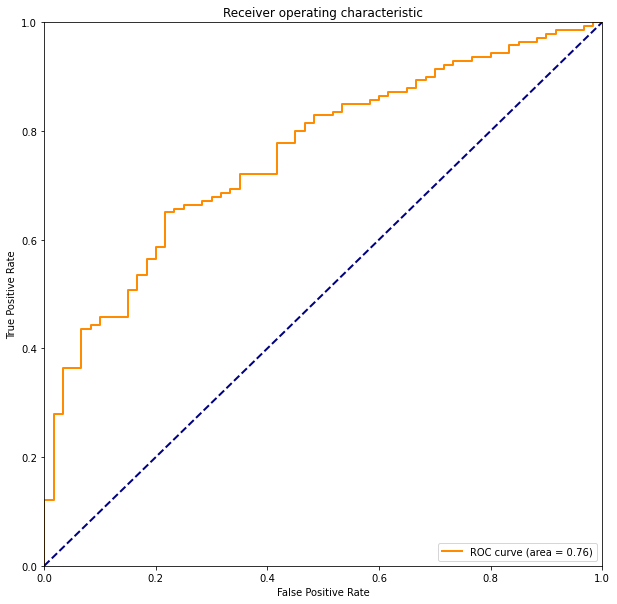

In [215]:
#@title Utility to plot the ROC-AUC curve and score.
def plot_auc(fpr: np.array, tpr: np.array) -> None:
  """Plots the ROC characteristic and the AUC Score

  Based on https://scikit-learn.org/stable/auto_examples/model_selection/
  plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

  Args:
    fpr: False positive rate
    tpr: True positive rate

  """

  fig, ax = plt.subplots(figsize=(10,10))
  roc_auc = metrics.auc(fpr, tpr)
  lw = 2
  ax.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc,
  )
  ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic")
  plt.legend(loc="lower right")
  plt.show()

plot_auc(fpr, tpr)

# 4 Common class definitions for comparing ML Algorithms

Now that we have a reasonable baseline performance, it’s reasonable to ask whether alternative learning algorithms might do a better job. However, some  algorithms may be in different ML libraries, like Keras, PyTorch, TensorFlow, or stand-alone libraries posted in Github. Some libraries might not expose the same methods as `fit()` or `predictproba()`, so it’s useful to define an base class and use standard object-oriented programming and extend the base class with a specific implementation. This way we can run the same train/eval process for various different learning algorithms in a consistent manner.

Below, we defined abstract `BaseLearningAlgorithm` that defines `train()`, `predict()` methods, and a name property for labeling the plots. Then, we create a very simple wrapper class `LogisticRegressionLearningAlgorithm`.



In [216]:
class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def train(self, X_train:np.array, y_train: np.array) -> None:
    """Trains a model from labels y and examples X."""

  @abstractmethod
  def predict(self, X_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""


class LogisticRegressionLearningAlgorithm:
  """Logistic Regression implementation of BaseLearningAlgorithm."""

  def __init__(self, max_iter):
    self._model = LogisticRegression(random_state=0, max_iter = max_iter)

  def train(self, X_train:np.array, y_train: np.array) -> None:
    """Trains a model from labels y and examples X."""
    # y_train = y_train.reshape(y_train.shape[0],)
    self._model.fit(X_train, y_train)

  def predict(self, X_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""
    return self._model.predict_proba(X_test)[:, 1]

  @property
  def name(self) -> str:
    return "Logistic Regression"


In [217]:
logreg = LogisticRegressionLearningAlgorithm(max_iter= 1000)
logreg.train(X_train, y_train)
logreg_preds = logreg.predict(X_test)

# calculating the ROC-AUC score
fpr, tpr, thresholds = metrics.roc_curve(y_test, logreg_preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print('The ROC-AUC is %3.3f' %roc_auc)

The ROC-AUC is 0.757


# 5 Cross-fold Validation
Even though we’re in the era of ‘Big Data’, high-quality labeled data is ironically still hard to get in large quantities. With only 1,000 labeled data points in our data set, we have only 800 for training and 200 for test. So, we want to maximize the use of our data without accidentally overfitting.

Our next model will be a dense neural network with many different settings, or hyperparameters. Some hyperparameter settings yield better performance than others, which we’ll explore in the following sections.

Suppose we choose hyperparameters, train our model on the 80%, test our model on 20%, and adapt the hyperparameters, and repeat this process maximizing the performance. There is still a danger of overfitting to the test set since we’re selecting hyperparameters that fit the test set best. If we deploy this model on a new dataset, we may observe degraded performance because the model was tuned to the test set.

To prevent overfitting to the test set, we must perform our hyperparameter search on the 80% training set using cross-fold validation, and then publish final results using the 20% test set.

In cross-fold validation, you take the original 80% training set, and split it into $k$ equally sized splits, train $k$ models on $k-1$ splits, test on the one split not used in the not in the $k-1$ splits used in training. Repeat the process $k$-times with $k$ results (here, AUC scores, TPRs, and FPRs). Then for the next iteration, choose a different set of hyperparameters, and repeat the process. Train a model using the best hyperparameters, and finally report the final results on the original 20% test data set that was not used while iterating on hyperparameters. For a detailed explanation, please see Algorithm 5.1, p120 in Goodfellow, and  [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html).

While you can choose any $k > 2$, the most common choices of $k$ are 3, 5, and 10. Here, we’ll specify `K_FOLDS=5`.

While Scikit-Learn provides utilities for cross-fold validation, it’s instructive to write our own solution using Algorithm 5.1 as a reference and the BaseLearningAlgorithm we created above.


In [218]:
K_FOLDS = 5 # % splits of 80%/20% each

In [219]:
#@title Perform cross-validation train and eval
Examples = np.array # [M examples, N features]
Labels  = np.array # [M Labels]
Results = Mapping[str, List[float]] # keys = roc_aus, fpr, tpr
Fold = Tuple[Examples, Labels] # A single fold consists of examples and labels.

def split_folds(X: np.array, y: np.array, k_folds: int) ->  List[Fold]:
  """Splits the data into consecutive folds.

  Args:
    X: n-d Array of examples
    y: 1-d array of labels
    k_folds: number of folds

  Returns:
    List of tuples of (X_i, y_i) i <= n_folds
  """
  if X.shape[0] != y.shape[0]:
    raise ValueError('The number of examples didn\'t match match (|X| = %d and |y| = %d).', X.shape[0], y.shape[0])
  split_size = int(X.shape[0]/k_folds)
  folds = []
  for fold_id in range(k_folds):
    start_ix  = fold_id * split_size
    end_ix = (fold_id + 1)* split_size
    folds.append((X[start_ix: end_ix, :], y[start_ix: end_ix] ))

  return folds


def train_eval_xval(X: np.array, y: np.array,  k_folds: int, learning_algorithm: BaseLearningAlgorithm) -> Results:
  """Executes Cross-fold Train and Evaluation.

  See Algorithm 5.1 (p. 120) in Goodfellow for implementation details. Instead
  of minimizieng Loss Function, we'll be maximizing the AUC, which is already
  a part of the BaseLearningAlgorithm predict() method.

  Args:
    X: An M x N array of examples
    y: An N x 1 array of binary class labels
    k_folds: The number of folds for cross-fold validation.
    learning_algorithm: The algorithm being evaluated.

  Returns:
    A Results distcionary with True Pos Rate, False Pos Rate, and ROC-AUC.
  """

  folds = split_folds(X, y, k_folds)

  results_fpr = []
  results_tpr = []
  results_roc_auc = []

  for fold_id in range(k_folds):
    fold_indexes = np.arange(k_folds) # Creates a list of [0,...,k-1]

    test_fold_index = fold_id # The test set is the fold id.

    # Get the list of training indexes be removing the test index.
    training_fold_indexes = np.delete(fold_indexes, fold_id)

    # Create training set of examples and labels excluding test fold.
    X_train = np.vstack([folds[k][0] for k in training_fold_indexes])
    y_train = np.hstack([folds[k][1] for k in training_fold_indexes])

    # Create a test set with labels for the test fold.
    X_test = folds[test_fold_index][0]
    y_test = folds[test_fold_index][1]

    # Train the learning algorithm on the training set with labels.
    learning_algorithm.train(X_train, y_train)

    # Using the test set get the predictions.
    predictions = learning_algorithm.predict(X_test)

    # Compute the false positive and true positive rates.
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    # Get the ROC Area under the curve, by integrating the fpr/tpr curve.
    roc_auc = metrics.auc(fpr, tpr)

    # Place the results into lists of length k.
    results_fpr.append(fpr)
    results_tpr.append(tpr)
    results_roc_auc.append(roc_auc)

  return {'roc_auc': results_roc_auc, 'tpr': results_tpr, 'fpr': results_fpr}

# TODO: check max_iter...
learning_algorithm = LogisticRegressionLearningAlgorithm(max_iter= 1000)
results = train_eval_xval(X_train, y_train, K_FOLDS, learning_algorithm)
print("%s average auc = %3.3f" %(learning_algorithm.name, np.mean(results['roc_auc'])))




Logistic Regression average auc = 0.809


## Enhance the ROC/AUC Plot to display $k$ results
Since we are now getting $k$ ROC curves and $k$ AUC scores for each hyperparameter setting, we’ll want to enhance the plot to show the mean as a line and standard deviation of the folds as a shaded region around the lines. You can adapt the example provided by [Scikit-Learn]( https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py).


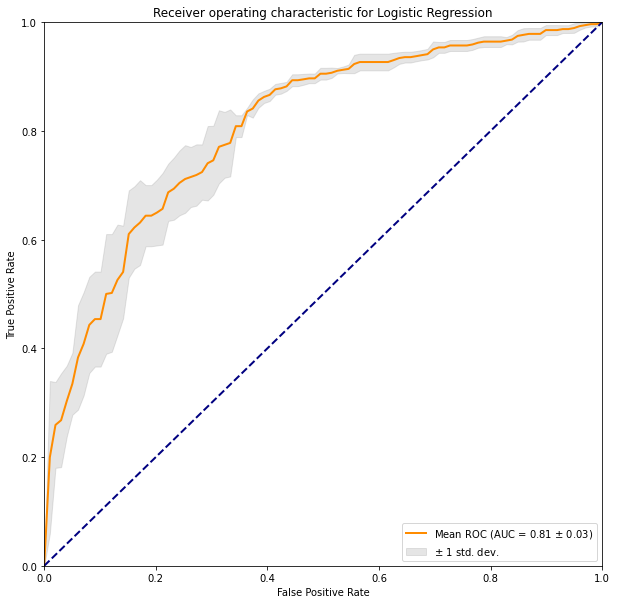

In [220]:
#@title Create AUC Plots for Cross-Fold Validation
def plot_auc_xfold(results, algorithm_name):
  """Plots ROC characteristics for X-fold validation runs.

  See Scikit-Learn implementation as a basis:
  https://scikit-learn.org/stable/auto_examples/model_selection/
  plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

  Args:
    results: Dict of tprs, fprs, and auc from k-folds.
    algorithm_name: Name for labeling the chart.

  """
  k_folds = len(results['tpr'])
  fig, ax = plt.subplots(figsize=(10,10))
  fprs = [results['fpr'][i] for i in range(k_folds)]
  tprs = [results['tpr'][i] for i in range(k_folds)]

  # Since the fprs and tprs don't necessarily have the same lengths,
  # we need to apply linear interpolation with 100 equal-sized steps between
  # 0 and 1.
  mean_fpr = np.linspace(0, 1, 100)
  interp_tprs = []
  for i in range(k_folds):
    interp_tpr = np.interp(mean_fpr, fprs[i], tprs[i])
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)

  mean_tpr = np.mean(interp_tprs, axis=0)
  mean_tpr[-1] = 1.0

  # Compute mean & standard deviation of the AUC.
  mean_auc = metrics.auc(mean_fpr, mean_tpr)
  std_auc = np.std(results['roc_auc'])

  lw = 2
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="darkorange",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=lw,
  )

  std_tpr = np.std(interp_tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  plt.legend(loc="lower right")
  ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic for %s" %algorithm_name)
  plt.show()

plot_auc_xfold(results, learning_algorithm.name)

Since we're training on 80% of 80% (64%) 5 times, we aren't surprised that the average AUC is slightly lower than when we trained on the entire test set. Maybe we can do a better job with a Deep Learning, nonlinear classifier!

## Train and Evaluate a Dense Neural Network Classifier

Let’s define a **Dense Neural Network (DNN)** classifier. Unlike Logistic Regression, a DNN is a nonlinear classifier. We’ll use TensorFlow’s Keras API to define a simple classifier and wrap it inside an extension class to BaseLearningAlgorithm defined above. TensorFlow is a lower-level library that exposes a Keras-compatible programming interface. You can use either the [Keras library](https://keras.io/), or the [TensorFlow Keras API](https://www.tensorflow.org/guide/keras).

An incomplete implementation of `DenseNNLearningAlgorithm` is provided below to get you started, but also provide you with some initial experience in creating a neural network using the Keras API. Don’t worry too much about some unfamiliar concepts like *binary cross-entropy loss*, *ReLU activation*, *dropout layers*, etc. We’ll cover them in greater detail during the class. You should become familiar with How Sequential models are define, and how to assemble a multi-layered model using Dense and Dropout layers.

Also, neural networks tend to be sensitive to features with different ranges that can lead to vanishing or exploding gradients, which we’ll explore later in greater detail. To minimize the danger, it’s advisable to normalize the data, by shifting by the mean and dividing by the standard deviation, using the following equation $$\hat{x}_{d} = \frac{x_d-\mu_d}{\sigma_d} $$

where:
*  $\hat{x}_d$: Normalized feature indexed by $d$
*  $x_d$: Native (original) feature indexed by $d$
*  $\mu_d$: Feature mean indexed by $d$
*  $\sigma_d$: Feature standard deviation indexed by $d$




Of course, you’ll want to use exactly the same $\mu$ and $\sigma$ in training and in test (i.e., calculate/use in the `train()`, and use it in `predict()`).


In [221]:
#@title Train and Evaluate a Dense Neural Network Classifier

class DenseNNLearningAlgorithm(BaseLearningAlgorithm):
  """Base class for a Supervised Learning Algorithm."""

  def __init__(self, input_dim: int, dropout: float, layer_width: int,
                n_hidden_layers: int, epochs: int, steps_per_epoch: int,
                batch_size: int, optimizer: str):
    self._epochs = epochs
    self._steps_per_epoch = steps_per_epoch
    self._batch_size = batch_size
    self._model = self._get_model(input_dim,  dropout, layer_width,
                 n_hidden_layers, optimizer)


  def _get_model(self, input_dim: int, dropout: float, layer_width: int,
                 n_hidden_layers: int, optimizer: str) -> tf.keras.Sequential:
    """Creates a Keras Neural Network model for Classification.
    Creates a simple stack of dense/dropout layers with equal width.
    Args:
      input_dim: width of the input layer
      dropout: dropout probability for each hidden layer
      layer_width: hidden layer width
      n_hidden_layers: number of hidden layers
      optimizer: Name of the optimizer in use
    Returns:
      tf.keras.Sequential model.
    """
    # Define the a Sequential Keras model.
    model = tf.keras.Sequential()

    # Add a Dense layer of input_dim, and layer_width, select ReLu activation,
    # and add one Dropout layer.
    model.add(
        tf.keras.layers.Dense(
            layer_width, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))

    # Next, add a Dense of layer_width, and ReLu activation, and Dropout layer
    # for each hidden_layer in the loop.
    for _ in range(n_hidden_layers):
      model.add(tf.keras.layers.Dense(layer_width, activation='relu'))
      model.add(tf.keras.layers.Dropout(dropout))

    # Add a Dense output layer with a single output with a
    # sigmoid activaton to squees the outputs into a probability-like range.
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Now compile the model, by specifying a binary cross-entropy loss,
    # and setting the optimizer from the input arguments.
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=[tf.keras.metrics.binary_accuracy])
    return model


  def train(self, X_train:np.array, y_train: np.array) -> None:
    """Trains a model from labels y and examples X."""

    # Compute the means and standard deviations for each feature.
    # Hint: make these class variables so you can use them in testing.
    self._st_devs = np.std(X_train, axis = 0)
    self._means = np.mean(X_train, axis = 0)

    # Now normlize the training data.
    X_train_normalized  = (X_train - self._means)/self._st_devs

    # Create datasets for both examples and labels
    dx = tf.data.Dataset.from_tensor_slices(X_train_normalized)
    dy = tf.data.Dataset.from_tensor_slices(y_train)

    # Zip the two datasets together into a [X|y] training dataset.
    train_dataset = tf.data.Dataset.zip(
        (dx, dy)).shuffle(50).repeat().batch(self._batch_size)

    # Similar to LogisticRegresssion, invoke the fit() method.
    self._model.fit(
        x=train_dataset,
        steps_per_epoch=self._steps_per_epoch,
        verbose=0,
        epochs=self._epochs,
        )

  def predict(self, X_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

    # Normalize the test data using the constants computer earlier.
    X_test_normalized  = (X_test - self._means)/self._st_devs
    # Then invoke the predict method.
    return self._model.predict(X_test_normalized, verbose=1, steps=1)

  @property
  def name(self) -> str:
    return "Dense NN"


Let's invoke the DNNmodel. The handy Keras plotting utility can display the network architecture.

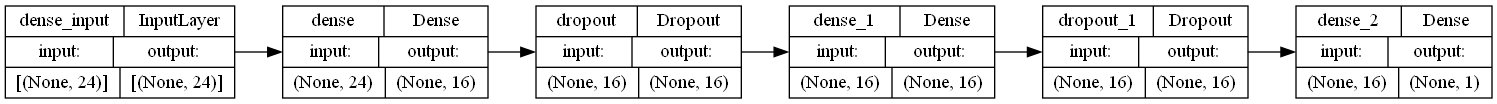

In [222]:
#@title Instantiate and display the DNN CLassifier

learning_algorithm =  DenseNNLearningAlgorithm( input_dim = 24, dropout = 0.1, layer_width = 16,
                 n_hidden_layers = 1, epochs = 25, steps_per_epoch = 8, batch_size = 64, optimizer = 'sgd')
tf.keras.utils.plot_model(learning_algorithm._model, show_shapes=True, rankdir="LR")


## Question 5.1
How many parameters are in this model compared to the number of parameters in the Logistic Regression model?

## Answer
For the above Dense model architecture, there are 689 parameters, calculated as the sum of the parameters of each layer. As for the Logistic Regression model, there are 25 parameters, calculated as the sum of the parameters of the input layer and the bias (or the intercept) since the task we are concerned with is a binary classification task.

We can see the number of parameters by:
- Using the `model.summary()` method for the Dense model


In [223]:
learning_algorithm._model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                400       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 689 (2.69 KB)
Trainable params: 689 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we can execute cross-fold train/eval and chart the ROC curve and AUC on the same data like with Logistic Regression, just with the DNN.

1/1 [==============================] - 0s 17ms/step
Dense NN average auc = 0.736


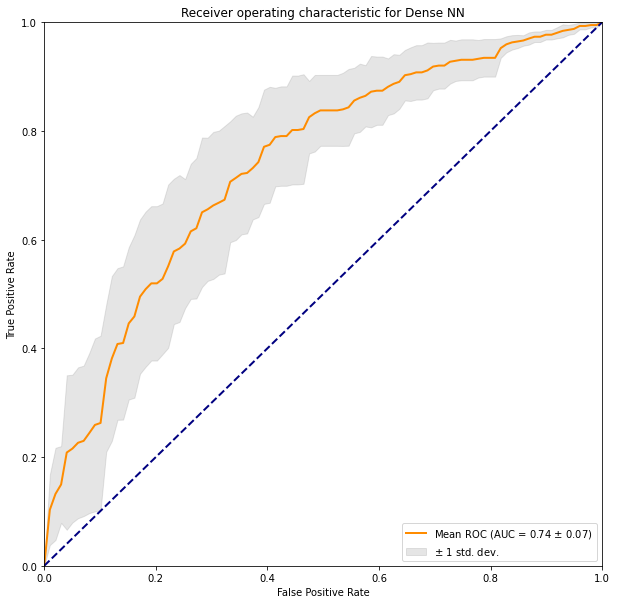

In [224]:
results = train_eval_xval(X_train, y_train, K_FOLDS, learning_algorithm)
print("%s average auc = %3.3f" %(learning_algorithm.name, np.mean(results['roc_auc'])))
plot_auc_xfold(results, learning_algorithm.name)

## Question 5.2
Compare the AUC scores and the ROC charts from DNN and Logistic Regression. Is one model approach better than the other? Explain the differences or similarities in the performances of both learning algorithms.

## Answer



# 6 Hyperparameter Tuning the DNN Classifier with hparams

We can speculate that the original hyperparameters weren't ideal that lead to
less impressive results. We would like an automatic way of searching through the hyperparameter space.


Let's see if we can find better parameters for the Dense NN. First, we have to choose the parameters we'd like to investigate:


*   Dropout (Probability that a node will be dropped in training.)
*   Layer Width (i.e., number of nodes in the layer)
*   Number of hidden layers
*   The optimizer: RMS Prop, SGD, and Adam

Then we need to specify the possible intervals and ranges. For example, we may not want to try 1, 2,..., 999, 1000 layers. Instead we might find it more efficient to try powers of 2 to save some time.

We'll search through the hyperparameter space using grid search, which works well for small models and limited search spaces. Other algorithms exist that are more efficient (but less complete) in searching through the hyperparameter space.

We'll be using [TensorBoard](https://www.tensorflow.org/tensorboard), TensorFlow's visualization toolkit to gain some insights into performance from the different hyperparameter settings. Specifically, the HParams view will be useful in tuning our algorithm.

Additional details are provided in [Hyperparameter Tuning with the HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams), which was largely adapted here to our classification problem.


First, loadup TensorBoard and clear out any old data if necessary.

In [225]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [226]:
# Clear any logs from previous runs
! rm -rf ./logs/

Next define the hyperparameter ranges using` hp.HParam`, `hp.RealInterval`, and `hp.Discrete`. A good set of ranges to explot might be:

*  `dropout`: {0.0, 0.05, ..., 0.2},
*  `num_units`: {8, 16, 32, 64},
*  `num_layers`: {1, 2, 3},
*  `optimizer`: {`adam`, `sgd`, and `rmsprop`}


In [229]:
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.00, 0.20))
# TODO: define multiple discrete steps [4, 8, 12, .., 48] for layer width and call it HP_LAYER_WIDTH
# create a list of layer widths
hp_layer_width_list = list(range(4, 49, 4))
HP_LAYER_WIDTH = hp.HParam('layer_width', hp.Discrete(hp_layer_width_list))
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([1,2,3]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))

METRIC_AUC = 'auc'
# Set up the hparams configuration and write file.
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_DROPOUT, HP_LAYER_WIDTH, HP_NUM_LAYERS, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_AUC, display_name='AUC')],
  )

For each run, log an hparams summary with the hyperparameters and AUC:

In [231]:

def train_test_model(hparams):

  learning_algorithm =  DenseNNLearningAlgorithm( input_dim = 24, dropout = hparams[HP_DROPOUT], layer_width = hparams[HP_LAYER_WIDTH],
                 n_hidden_layers = hparams[HP_NUM_LAYERS], epochs = 25, steps_per_epoch = 8, batch_size = 64, optimizer =  hparams[HP_OPTIMIZER])
  results = train_eval_xval(X_train, y_train, K_FOLDS, learning_algorithm)
  mean_auc = np.mean(results['roc_auc'])
  print("%s average auc = %3.3f, min auc = %3.3f, max auc = %3.3f" %(learning_algorithm.name, mean_auc,  np.min(results['roc_auc']),  np.max(results['roc_auc']) ))
  return  np.mean(results['roc_auc'])



In [232]:
def run(run_dir, hparams, step):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    mean_auc = train_test_model(hparams)
    tf.summary.scalar(METRIC_AUC, mean_auc, step=step)

You can now try multiple experiments, training each one with a different set of hyperparameters.

For simplicity, use a grid search: try all combinations of the discrete parameters and just the lower and upper bounds of the real-valued parameter. For more complex scenarios, it might be more effective to choose each hyperparameter value randomly (this is called a random search). There are more advanced methods that can be used.

Feel free to enjoy a coffee or tea at this point, and let the computer work for you. ☕


## Question 6.1
What are the advantages and disadvantages of grid search? What alternative search approaches might you consider if it's not feasible to perform a robust grid search?

## Answer


In [233]:
session_num = 0
hp_step = 0.05
dropout_rate = 0
for num_units in HP_LAYER_WIDTH.domain.values:
  for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, hp_step):
    for num_layers in HP_NUM_LAYERS.domain.values:
      for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_LAYER_WIDTH : num_units,
            HP_DROPOUT: dropout_rate,
            HP_NUM_LAYERS: num_layers,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams, session_num)
        session_num += 1


--- Starting trial: run-0
{'layer_width': 4, 'dropout': 0.0, 'num_layers': 1, 'optimizer': 'adam'}
1/1 [==============================] - 0s 18ms/step
Dense NN average auc = 0.749, min auc = 0.625, max auc = 0.828
--- Starting trial: run-1
{'layer_width': 4, 'dropout': 0.0, 'num_layers': 1, 'optimizer': 'rmsprop'}
1/1 [==============================] - 0s 18ms/step
Dense NN average auc = 0.794, min auc = 0.755, max auc = 0.832
--- Starting trial: run-2
{'layer_width': 4, 'dropout': 0.0, 'num_layers': 1, 'optimizer': 'sgd'}
1/1 [==============================] - 0s 19ms/step
Dense NN average auc = 0.734, min auc = 0.661, max auc = 0.774
--- Starting trial: run-3
{'layer_width': 4, 'dropout': 0.0, 'num_layers': 2, 'optimizer': 'adam'}
1/1 [==============================] - 0s 20ms/step
Dense NN average auc = 0.782, min auc = 0.753, max auc = 0.832
--- Starting trial: run-4
{'layer_width': 4, 'dropout': 0.0, 'num_layers': 2, 'optimizer': 'rmsprop'}
1/1 [==============================] - 0

The left pane of the dashboard provides filtering capabilities that are active across all the views in the HParams dashboard:

*  Filter which hyperparameters/metrics are shown in the dashboard
*   Filter which hyperparameter/metrics values are shown in the dashboard
*   Filter on run status (running, success, ...)
* Sort by hyperparameter/metric in the table view
Number of session groups to show (useful for performance when there are many experiments)

The HParams dashboard has three different views, with various useful information:

*  The Table View lists the runs, their hyperparameters, and their metrics.
*  The Parallel Coordinates View shows each run as a line going through an axis for each hyperparemeter and metric. Click and drag the mouse on any axis to mark a region which will highlight only the runs that pass through it. This can be useful for identifying which groups of hyperparameters are most important. *  The axes themselves can be re-ordered by dragging them.
* The Scatter Plot View shows plots comparing each hyperparameter/metric with each metric. This can help identify correlations. Click and drag to select a region in a specific plot and highlight those sessions across the other plots.

A table row, a parallel coordinates line, and a scatter plot market can be clicked to see a plot of the metrics as a function of training steps for that session (although in this tutorial only one step is used for each run).


In [ ]:
%tensorboard --logdir logs/hparam_tuning

## Question 6.2
Describe the results of hyperparameter tuning. Were you able to find a set of hyperparameters that yielded better performance than Logistic Regression? What was the best AUC score you were able to achieve? What hyperparameter settings made the largest contribution?

##Answer




# 7 Comparing Logistic Regression against DNN Classifiers

Next, choose the ebst hyperparameter values and execute train the model


In [ ]:
#@title Instantiate and display the DNN Classifier
dropout = 0.0
num_layers =3
num_units =48
optimizer = 'adam'
learning_algorithm =  DenseNNLearningAlgorithm( input_dim = 24, dropout = 0.0, layer_width = num_units,
                 n_hidden_layers = num_layers, epochs =25, steps_per_epoch = 8, batch_size = 64,  optimizer = optimizer)


learning_algorithm.train(X_train, y_train)

# Using the test set get the predictions.
predictions = learning_algorithm.predict(X_val)

# Compute the false positive and true positive rates.
fpr, tpr, _ = metrics.roc_curve(y_val, predictions)
roc_auc = metrics.auc(fpr, tpr)
print('The ROC-AUC is %3.3f' %roc_auc)
plot_auc(fpr, tpr)

##Question 7.1
Compare and contrast linear models with nonlinear classifier models. What are the advantages and disadvantages of either?

## Answer


## Question 7.2
When you train a new model using the hyperparameters from the best run, are you able to match or exceed logistic regression?

## Answer


## Question 7.3
You should always get the same result when executing Logistic Regression ifthe data set is fixed. However, when running the DNN multiple times, you'll get different results. Can you provide an explanation about what makes the DNN produce different results, even when being trained on the same data?

## Answer


## Question 7.4
Given this experiment, when do you think it's appropriate to use linear instead nonlinear methods, like DNNs?

## Answer